In [1]:
import pandas as pd
import glob
import numpy as np
import math
from scipy import stats

import matplotlib.pyplot as plt

import matplotlib.patheffects as path_effects
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning removal

In [2]:
def running_average(arr, window=5):
    # Compute the running average using convolution
    conv_avg = np.convolve(arr, np.ones(window) / window, mode='valid')
    # Prepend and append additional averages as needed
    start_avgs = [np.mean(arr[:3]), np.mean(arr[:4])]
    end_avgs = [np.mean(arr[-4:]), np.mean(arr[-3:])]
    # Combine everything into one array
    return np.concatenate((start_avgs, conv_avg, end_avgs))

In [3]:
def mk_obs_mo(time_scale):
    dir = '/projects/COLA/land/skim/FLUXNET/AMERIbase/out_v2/'
    site_list = sorted(glob.glob(dir+'US-*.csv'))
    f_start = 0 ; f_stop = len(site_list)
    
    columns    = ['NETRAD_1_A','LE_1_A','H_1_A','G_1_A','SWC_1_A']
    columns_mo = ['1','2','3','4','5','6','7','8','9','10','11','12']

    rad_out    =  pd.DataFrame(columns=columns_mo)
    le_out     =  pd.DataFrame(columns=columns_mo)
    sh_out     =  pd.DataFrame(columns=columns_mo)
    gh_out     =  pd.DataFrame(columns=columns_mo)
    swc_out    =  pd.DataFrame(columns=columns_mo)
    
    siteid = []
    
    for s,site in enumerate(site_list[0:f_stop]):
    # for s,site in enumerate(site_list[0:1]):
        f_siteid = site.split("/")[8].split("_")[0][:6]
        df   = pd.read_csv(site,na_values=-9999)
        
        tm      = df['TIME']    
        yrs     = str(tm[0])[:4]   ;    yre     = str(tm[int(len(tm)-1)])[:4]
        mos     = str(tm[0])[4:6]  ;    moe     = str(tm[int(len(tm)-1)])[4:6]
        dys     = str(tm[0])[6:8]  ;    dye     = str(tm[int(len(tm)-1)])[6:8]
        hrs     = str(tm[0])[8:10] ;    hre     = str(tm[int(len(tm)-1)])[8:10]
        mns     = str(tm[0])[10:12];    mne     = str(tm[int(len(tm)-1)])[10:12]

        time = pd.date_range(yrs+'-'+mos+'-'+dys+' '+hrs+':'+mns,yre+'-'+moe+'-'+dye+' '+hre+':'+mne,freq='30MIN')        
        df.index = pd.to_datetime(time)
        
        rad    = df[columns[0]].resample(time_scale).mean()    
        le     = df[columns[1]].resample(time_scale).mean()
        sh     = df[columns[2]].resample(time_scale).mean()
        gh     = df[columns[3]].resample(time_scale).mean()
        swc1   = df[columns[4]].resample(time_scale).mean()
        
        sort_nan = ~np.logical_or.reduce((np.isnan(rad),np.isnan(le),np.isnan(sh),np.isnan(gh),np.isnan(swc1)))
    
        tm_indx = rad.index[sort_nan]
        month = rad.index.month[sort_nan]
        rad   = rad[sort_nan]
        le    = le [sort_nan]
        sh    = sh [sort_nan]
        gh    = gh [sort_nan]        
        swc1  = swc1[sort_nan]
        
        if int(yre) > 2020:
            month = month[rad.index.year <= 2020]
            rad = rad[rad.index.year <= 2020]
            le  = le [le.index.year <= 2020]
            sh  = sh [sh.index.year <= 2020]
            gh  = gh [gh.index.year <= 2020]
            swc1= swc1[swc1.index.year <= 2020]
        
        if int(yrs) < 2021:
            rad_monthly  = []
            le_monthly   = []
            sh_monthly   = []
            gh_monthly   = []
            swc_monthly  = []
        
            for i in range(1,13):
                if (len(rad[month == i]) >= 90.):
                    rad_mo   = np.nanmedian(running_average(rad[month == i]))
                    le_mo    = np.nanmedian(running_average(le[month == i]))
                    sh_mo    = np.nanmedian(running_average(sh[month == i]))
                    gh_mo    = np.nanmedian(running_average(gh[month == i]))
                    swc_mo   = np.nanmedian(running_average(swc1[month == i]))
                else:
                    rad_mo    = np.nan
                    le_mo     = np.nan
                    sh_mo     = np.nan
                    gh_mo     = np.nan
                    swc_mo    = np.nan
     
                rad_monthly.append(rad_mo)
                le_monthly.append(le_mo)
                sh_monthly.append(sh_mo)
                gh_monthly.append(gh_mo)
                swc_monthly.append(swc_mo)
 
            rad_in  = pd.DataFrame([rad_monthly], columns=columns_mo)
            le_in   = pd.DataFrame([le_monthly], columns=columns_mo)
            sh_in   = pd.DataFrame([sh_monthly], columns=columns_mo)
            gh_in   = pd.DataFrame([gh_monthly], columns=columns_mo)
            swc_in  = pd.DataFrame([swc_monthly], columns=columns_mo)
            
            rad_out   = pd.concat([rad_out,rad_in], ignore_index=True)
            le_out    = pd.concat([le_out,le_in], ignore_index=True)
            sh_out    = pd.concat([sh_out,sh_in], ignore_index=True)
            gh_out    = pd.concat([gh_out,gh_in], ignore_index=True)
            swc_out    = pd.concat([swc_out,swc_in], ignore_index=True)            
        
            siteid.append(f_siteid)
            del df
        
    
    print('done')
    return swc_out, rad_out, le_out, sh_out, gh_out, siteid

In [4]:
obs = mk_obs_mo('1D')

done


In [5]:
swc_obs  = obs[0]
rad_obs  = obs[1]
le_obs   = obs[2]
sh_obs   = obs[3]
gh_obs   = obs[4]
site_obs = obs[5]

In [6]:
def get_obs_info(info,obs,f_siteid):
    columns_mo = ['1','2','3','4','5','6','7','8','9','10','11','12']
    var_ssnl   = []
    
    dir = '/projects/COLA/land/skim/FLUXNET/AMERIbase/out_v2/site/'
    df  = pd.read_csv(dir+f_siteid+'_site.csv',na_values=-9999)
    
    for i in range(1,13):
        value = obs.iloc[s][str(i)]
        if value is None or math.isnan(value):  # Skip if the value is None or NaN
            var_mo  = np.nan
        else:
            var_mo  = df[info].item()
            
        var_ssnl.append(var_mo)
        
    var_out  = pd.DataFrame(np.array([var_ssnl]), columns=columns_mo)
    
    return var_out

In [7]:
list = site_obs
f_start = 0 ; f_stop = len(list)

columns_mo = ['1','2','3','4','5','6','7','8','9','10','11','12']

lat_obs    =  pd.DataFrame(columns=columns_mo)
lon_obs    =  pd.DataFrame(columns=columns_mo)
igbp_obs   =  pd.DataFrame(columns=columns_mo)

for s,site in enumerate(list[f_start:f_stop]):
    f_siteid = list[s]
    # print(f_siteid)
    lon_in  = get_obs_info('Longitude',le_obs,f_siteid)
    lat_in  = get_obs_info('Latitude' ,le_obs,f_siteid)
    igbp_in = get_obs_info('IGBP type',le_obs,f_siteid)
    
    lon_obs  = pd.concat([lon_obs, lon_in], ignore_index=True)
    lat_obs  = pd.concat([lat_obs, lat_in], ignore_index=True)
    igbp_obs = pd.concat([igbp_obs,igbp_in], ignore_index=True)

    # print(loc_obs)
print('done')

done


In [8]:
# print(lat_obs)
# print(lat_obs.count())
lat_maskout = lat_obs <= 50
swc_obs   = swc_obs[lat_maskout]
rad_obs   = rad_obs[lat_maskout]
le_obs    = le_obs [lat_maskout]
sh_obs    = sh_obs [lat_maskout]
gh_obs    = gh_obs [lat_maskout]
# print(site_obs)

# # site_obs  = site_obs [lat_maskout]

# print(swc_obs.count())

# # print(site_obs)
# print(igbp_obs)
# print(gh_obs)


In [9]:
import pandas as pd
import numpy as np

# -------------------------------------------------------
# 1. NaN만 있는 행 제거 (즉, 하나라도 관측값 있는 행만 남김)
# -------------------------------------------------------
igbp_filtered = igbp_obs.dropna(how='all', axis=0)

# -------------------------------------------------------
# 2. vegetation type - IGBP 코드 매핑
# -------------------------------------------------------
veg_map = {
    "Forest": ["ENF", "EBF", "DNF", "DBF", "MF"],
    "Shrubland": ["CSH", "OSH"],
    "Savannas": ["WSA", "SAV"],
    "Grassland": ["GRA"],
    "Cropland": ["CRO", "CVM"],
    "Wetland": ["WET"],
    "Barren": ["BSV"],
    "Snow": ["SNO"]
}

# 코드 → veg_type 역매핑
igbp_to_type = {code: vtype for vtype, codes in veg_map.items() for code in codes}

# -------------------------------------------------------
# 3. 각 행(사이트)별 대표 veg_type 판정
# -------------------------------------------------------
site_types = []
site_codes = []

for _, row in igbp_filtered.iterrows():
    vals = row.dropna().unique()
    if len(vals) == 0:
        continue

    # 해당 행에 포함된 코드 중 빈도수 높은 코드 기준
    mode_code = pd.Series(vals).mode()[0]
    veg_type = igbp_to_type.get(mode_code, None)

    if veg_type:
        site_types.append(veg_type)
        site_codes.append(mode_code)

df_sites = pd.DataFrame({"Veg_Type": site_types, "IGBP": site_codes})

# -------------------------------------------------------
# 4. Veg_Type별 전체 비율
# -------------------------------------------------------
veg_counts = df_sites["Veg_Type"].value_counts()
veg_percent = veg_counts / veg_counts.sum() * 100

# -------------------------------------------------------
# 5. 각 Veg_Type 내 IGBP 코드 비율
# -------------------------------------------------------
sub_details = (
    df_sites.groupby(["Veg_Type", "IGBP"])
    .size()
    .reset_index(name="Count")
    .merge(veg_counts.rename("Total_Count"), on="Veg_Type")
)
sub_details["Percent_in_Type"] = sub_details["Count"] / veg_counts.sum() * 100

# -------------------------------------------------------
# 6. 결과 보기
# -------------------------------------------------------
print("\n=== Vegetation Type Summary ===")
print(pd.DataFrame({"Veg_Type": veg_percent.index, "Percent_Total": veg_percent.values}))

print("\n=== Detailed Breakdown by IGBP ===")
print(sub_details.sort_values(["Veg_Type", "Percent_in_Type"], ascending=[True, False]))



=== Vegetation Type Summary ===
    Veg_Type  Percent_Total
0     Forest      32.183908
1  Grassland      25.287356
2   Cropland      19.540230
3  Shrubland      13.793103
4    Wetland       4.597701
5     Barren       3.448276
6   Savannas       1.149425

=== Detailed Breakdown by IGBP ===
     Veg_Type IGBP  Count  Total_Count  Percent_in_Type
0      Barren  BSV      3            3         3.448276
1    Cropland  CRO     14           17        16.091954
2    Cropland  CVM      3           17         3.448276
4      Forest  ENF     15           28        17.241379
3      Forest  DBF     11           28        12.643678
5      Forest   MF      2           28         2.298851
6   Grassland  GRA     22           22        25.287356
7    Savannas  WSA      1            1         1.149425
9   Shrubland  OSH     10           12        11.494253
8   Shrubland  CSH      2           12         2.298851
10    Wetland  WET      4            4         4.597701


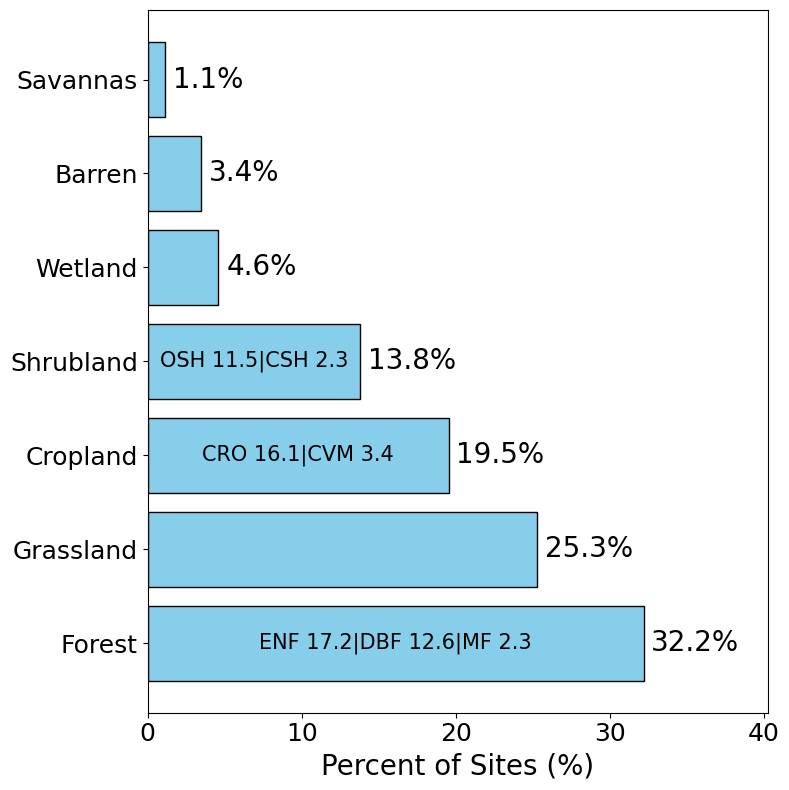

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# 1. 데이터 준비
# -------------------------------
summary_df = pd.DataFrame({
    "Veg_Type": ["Forest","Grassland","Cropland","Shrubland","Wetland","Barren","Savannas"],
    "Percent_Total": [32.183908,25.287356,19.540230,13.793103,4.597701,3.448276,1.149425]
})

detail_df = pd.DataFrame({
    "Veg_Type":["Barren","Cropland","Cropland","Forest","Forest","Forest","Grassland","Savannas","Shrubland","Shrubland","Wetland"],
    "IGBP":["BSV","CRO","CVM","ENF","DBF","MF","GRA","WSA","OSH","CSH","WET"],
    "Percent_in_Type":[3.448276,16.091954,3.448276,17.241379,12.643678,2.298851,25.287356,1.149425,11.494253,2.298851,4.597701],
    "Total_Count":[3,17,17,28,28,28,22,1,12,12,4]
})

# -------------------------------
# 2. bar plot
# -------------------------------
fig, ax = plt.subplots(figsize=(8,8))
bars = ax.barh(summary_df["Veg_Type"], summary_df["Percent_Total"], color="skyblue", edgecolor="black")

# -------------------------------
# 3. Forest, Cropland, Shrubland 세부 IGBP 구성 텍스트 표시
# -------------------------------
target_types = ["Forest", "Cropland", "Shrubland"]

for i, (veg, total) in enumerate(zip(summary_df["Veg_Type"], summary_df["Percent_Total"])):
    if veg in target_types:
        sub = detail_df[detail_df["Veg_Type"] == veg]
        sub_texts = [f"{r.IGBP} {r.Percent_in_Type:.1f}" for r in sub.itertuples()]
        text = "|".join(sub_texts)
        ax.text(total/2, i, text, ha='center', va='center', fontsize=15, color='black')

# -------------------------------
# 4. 각 bar 끝에 퍼센트 라벨 추가
# -------------------------------
for bar in bars:
    width = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    ax.text(width + 0.5, y, f"{width:.1f}%", va='center', ha='left', fontsize=20, color='black')

# -------------------------------
# 5. 그래프 스타일
# -------------------------------
ax.set_xlabel("Percent of Sites (%)",fontsize=20)
# ax.set_ylabel("Vegetation Type")
ax.set_xlim(0, summary_df["Percent_Total"].max() * 1.25)
ax.tick_params(axis="both", which="major", labelsize=18)        

plt.tight_layout()
plt.show()


Sup Fig1. 

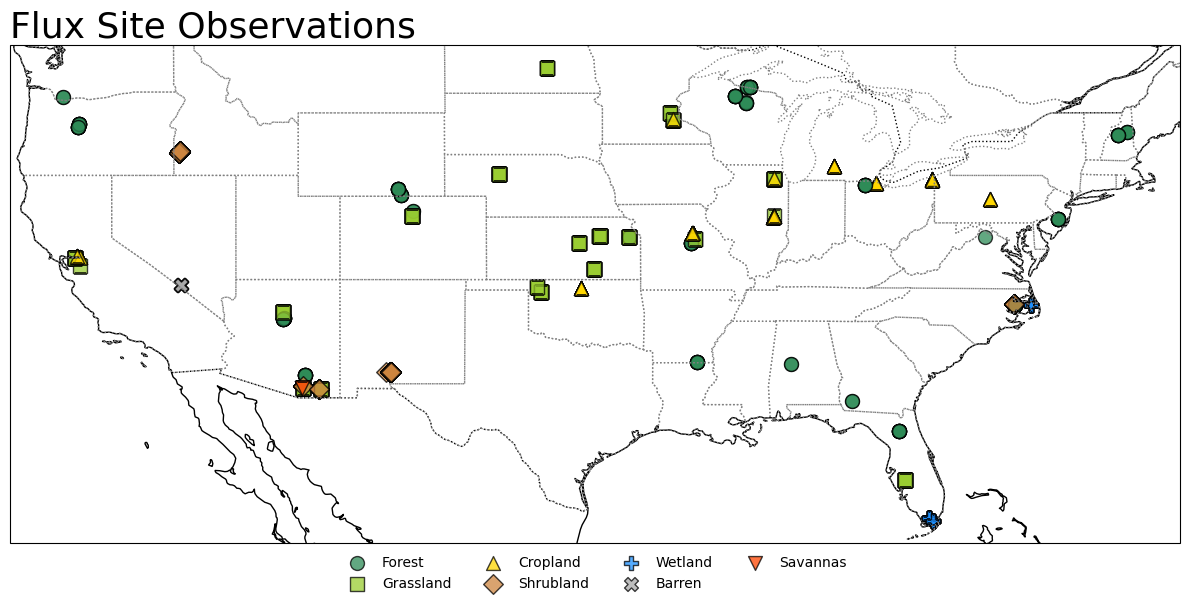

In [12]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
veg_map = {
    "Forest": ["ENF", "EBF", "DNF", "DBF", "MF"],
    "Shrubland": ["CSH", "OSH"],
    "Savannas": ["WSA", "SAV"],
    "Grassland": ["GRA"],
    "Cropland": ["CRO", "CVM"],
    "Wetland": ["WET"],
    "Barren": ["BSV"],
    "Snow": ["SNO"]
}

# 역매핑 (IGBP → VegType)
igbp_to_veg = {}
for veg, codes in veg_map.items():
    for code in codes:
        igbp_to_veg[code] = veg
        
# ---------------------------------------------
# 마커 및 색상 설정
# ---------------------------------------------
veg_markers = {
    "Forest": "o",        # circle
    "Grassland": "s",     # square
    "Cropland": "^",      # triangle up
    "Shrubland": "D",     # diamond
    "Wetland": "P",       # plus-filled
    "Barren": "X",        # X shape
    "Savannas": "v"       # triangle down
}

veg_colors = {
    "Forest": "#2E8B57",      # green
    "Grassland": "#9ACD32",   # yellow-green
    "Cropland": "#FFD700",    # gold
    "Shrubland": "#CD853F",   # brown
    "Wetland": "#1E90FF",     # blue
    "Barren": "#A9A9A9",      # gray
    "Savannas": "#FF4500"     # orange-red
}

# ---------------------------------------------
# 지도 설정
# ---------------------------------------------
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 8))

ax.coastlines(color='black', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black')
ax.add_feature(cfeature.STATES, linestyle=':', edgecolor='gray')

# ---------------------------------------------
# 월별로 Plot
# ---------------------------------------------
for month in range(1, 13):
    month_str = str(month)
    valid_mask = (lat_obs[month_str].notna() & lon_obs[month_str].notna() & igbp_obs[month_str].notna() & (lat_obs[month_str] <= 50))
    
    lats = lat_obs[month_str][valid_mask]
    lons = lon_obs[month_str][valid_mask]
    igbps = igbp_obs[month_str][valid_mask]
    
    # 각 IGBP 코드 → vegetation type
    vegs = igbps.map(igbp_to_veg)
    
    for veg in veg_markers.keys():
        mask = (vegs == veg)
        if mask.sum() == 0:
            continue
        ax.scatter(
            lons[mask],
            lats[mask],
            marker=veg_markers[veg],
            color=veg_colors[veg],
            s=100,
            edgecolors='black',
            transform=ccrs.PlateCarree(),
            alpha=0.75,
            label=veg if month == 1 else None
        )

# ---------------------------------------------
# 스타일 및 범례
# ---------------------------------------------
ax.set_title("Flux Site Observations", fontsize=26, loc='left')

# Legend 설정
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, ncol=4, loc='lower center', bbox_to_anchor=(0.5, -0.12), fontsize=10, frameon=False)

plt.tight_layout()
plt.show()